## Lab 7-1  Determine the Richardson Number and Turbulence Statistics from SOS data
developed/written May 2023 by Eli Schwat and edited by Jessica Lundquist


In [1]:
# We start by using pip to install a couple custom packages that make working with met data easier
# You can read more about the packages, which have lots of functionality here: https://unidata.github.io/MetPy/latest/examples/index.html 
!pip install metpy
!pip install pint-xarray

  Using cached MetPy-1.5.0-py3-none-any.whl (400 kB)
  Using cached Pint-0.21-py3-none-any.whl (286 kB)
  Using cached pint_xarray-0.3-py3-none-any.whl (32 kB)


In [2]:
import os
import urllib
from urllib.error import URLError
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

import metpy
from metpy.units import units
import pint_xarray

import matplotlib.pyplot as plt

# Inputs

Below, you can see that we are pulling in a lot of turbulence data.  These data are the mean values (one variable) and variances (two variables) over 5-minute intervals at each height.  w represents winds in the vertical direction, and u and v represent winds in the horizontal.  tc is the sonic temperature, based in the speed of sound, and h2o is the water vapor concentration (or specific humidity).  Thus, we represent vertical sensible heat flux by 'w_tc__height_tower' and vertical latent heat flux by 'w_h2o_height_tower'

In [3]:
# data is downloaded to this file path
sos_download_dir='sosnoqc'

# Specify start and end dates for the data. Specify the format that the dates are in.
# start_date = '20221201'
# end_date = '20221210'

# I'm picking the same dates we considered in Lab 6
start_date = '20230131'
end_date = '20230204'
DATE_FORMAT_STR = '%Y%m%d' # you shouldn't want to change this one

# Specify the variables you want to download. We are grabbing it ALL this time around.
VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
]

In [4]:
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

# Define some functions we will use

Some of these you have seen before.

In [5]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

def merge_datasets_with_different_variables(ds_list, dim):
    """ Allows merging of xarray datasets with different data variables.
    Takes a list of datasets and merges two at a time them using xr.merge, but first checks that the two datasets
    have the same data vars. If they do not, datasets with missing data vars have the missing data var added to them,
    with all nan values, so that the two datasets have the same set of data vars. 
    
    WARNING: This gets slow with lots of datasets
    Args:
        ds_list (_type_): _description_
        dim (_type_): _description_
    """
    def _merge_datasets_with_different_variables(ds1, ds2, dim):
        vars1 = set(ds1.data_vars)
        vars2 = set(ds2.data_vars)
        in1_notin2 = vars1.difference(vars2)
        in2_notin1 = vars2.difference(vars1)
        # add vars with NaN values to ds1
        for v in in2_notin1:
            ds1[v] = xr.DataArray(coords=ds1.coords, dims=ds1.dims)
        # add vars with NaN values to ds2
        for v in in1_notin2:
            ds2[v] = xr.DataArray(coords=ds2.coords, dims=ds2.dims)
        return xr.concat([ds1, ds2], dim=dim)

    new_ds = ds_list.pop(0)
    while ds_list:
        new_ds = _merge_datasets_with_different_variables(
            new_ds,
            ds_list.pop(0),
            dim=dim
        )
    return new_ds

from datetime import datetime
from dateutil.relativedelta import relativedelta
def date_range(start_date, end_date, increment, period):
    """Create a list of datetimes starting on a start_date, ending on end_date,
    with incrememnts of `increment` `period` between them.
    """
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta

    return result


def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc * units('celsius')
    return TTc


# Download SoS data

In [6]:
# Make sure that we aren't accessing variables that don't exist in the datasets.
# This is necessary because some daily NetCDF files don't have all the expected variables
# (for example because an instrument was down). In that case, we want to add that variable
# to the dataset, filled with nans, which sosutils.merge_datasets_with_different_variables
# handles for us
datasets = []
for date in datelist:
    try:
        ds = xr.open_dataset(download_sos_data_day(date, sos_download_dir, cache=True))
    # Some dates are missing
    except URLError:
        print(f"failed on {date}, skipping")
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)
# This becomes necessary if you are looking at data earlier in the season, or in the middle of the season when some measurements went offline (i.e. 1m sonics got buried)
sos_ds = merge_datasets_with_different_variables(datasets, dim='time')

Caching...skipping download for 20230131
Caching...skipping download for 20230201
Caching...skipping download for 20230202
Caching...skipping download for 20230203
Caching...skipping download for 20230204


# Fill in missing timestamps (with nans)

Note that this occurs if there is missing data (i.e. power went down) at the beginning or end of day - those timestamps will be left out of the dataset. 

The following code makes sure that if a timestamp is missing from the dataset, it is added with NaNs for all variables.

This results in daily datasets of different size (for example, the 20221201 dataset is missing data at the end of the day), which is annoying and can get confusing when you merge datasets together

In [7]:
dt_list = date_range(pd.to_datetime(sos_ds.time.values[0]), pd.to_datetime(sos_ds.time.values[-1]), 5, 'minutes')

In [8]:
sos_ds = sos_ds.reindex(time=dt_list)

# Calculate new variables

## Calculate surface temperatures

For calculating the temperature from the downward-facing, longwave radiometer, see EOL's methodology (https://www.eol.ucar.edu/content/calculation-long-wave-radiation)
$$
R_{lw} = R_{pile} + SB * T_{case}^4
$$
And the Steven-Boltzman law
$$
T_{surface} = \Big( \frac {R_{lw}}{ \epsilon \sigma } \Big)^\frac{1}{4}
$$

In [9]:
SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98
sos_ds['Tsurf_rad_d'] = ((sos_ds['Rpile_out_9m_d'] + SB * (sos_ds['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

# Surface Temperature
# calculate from apogees
sos_ds['Tsurf_c'] = (['time'], apogee2temp(sos_ds, 'c').values)
sos_ds['Tsurf_d'] = (['time'], apogee2temp(sos_ds, 'd').values)
sos_ds['Tsurf_ue'] = (['time'], apogee2temp(sos_ds, 'ue').values)
sos_ds['Tsurf_uw'] = (['time'], apogee2temp(sos_ds, 'uw').values)

## Calculate potential and virtual potential temperatures in the air

We iterate over every sonic-anemometer-height on the central (c) tower and calculate 5 new variables for each height:


mixingratio - **mixing ratio, r**
$$ r = \frac{0.622e_v}{p-e_v} $$
Remember that the mixing ratio is the ratio of the mass of water vapor to the mass of dry air only.  The specific humidity is the ratio of the mass of water vapor to the total mass of the air, but for practical purposes, we can presume they are the same.  $p$ is the air pressure (measured), and $e_v$ is the vapor pressure, which is calculated from the relative humidity (measured, in fractional form) times the saturated vapor pressure, which is an empirical function of temperature (measured) as shown in Lab 6-4.  



airdensity - **air density, $\rho$**
$$ p = \rho RT $$
From the ideal gas law, we can relate pressure to density, the gas constant for the specific gas, and the temperature (in Kelvin).  We know that the gas constant for dry air is $461.5 J kg^{-1} K^{-1}$, and the gas constant for water vapor is $286.9 J kg^{-1} K^{-1}$.  Knowing the observed pressure, temperature, and mixing ratio (calculated above) allows us to calculate the air density.



Tvirtual - **virtual temperature, $T_v$**
$$ T_v = T(1+0.61r) $$
where $T$ is the air temperature, and $r$ is the mixing ratio.  We use the virtual temperature to account for the fact that the density of air changes with water vapor concentration (moist air is less dense than dry air).  



Tpot - **potential temperature, $\theta$**
$$ \theta = T \Big(\frac{100}{p}\Big)^{\frac{R_a}{c_p}} $$
where $T$ is the air temperature in K, $p$ is the air pressure in kPa, $R_a$ is the specific gas constant for moist air, and $c_p$ is the specific heat for moist air.


Tpotvirtual - **virtual potential temperature, $\theta_v$**
This is an analagous adjustment as to the potential temperature, but it is done to the virtual temperature instead.




Note that we use the `metpy` library here, which assigns units to each dataarray, in an "object oriented" way using the `pint` library. You don't really have to worry about this, only to know that it can make working with the data more confusing. Know that at the end of the following cell, when we assign the new variables to the dataset, we remove any remnants of the `pint` library, and we assign an attribute `units` to each new variable so that they somewhat match the variables provided in the original dataset.

In [10]:
# Potential Temperature
# iterate over pressure measurements
for i in range(2,21):
    absolute_temperature = sos_ds[f'T_{i}m_c'] * units.celsius
    relative_humidity = sos_ds[f'RH_{i}m_c']
    absolute_pressure = sos_ds['P_10m_c'] * units.millibar
    height_relative_to_10m_pressure_sensor = i*units.m - (10*units.m)

    height_adj_pressure = metpy.calc.add_height_to_pressure(
        absolute_pressure, 
        height_relative_to_10m_pressure_sensor
    )
    potential_temperature = metpy.calc.potential_temperature(    
            height_adj_pressure,
            absolute_temperature
    ).pint.to(units.celsius)
    mixing_ratio = xr.DataArray(relative_humidity/100) * metpy.calc.saturation_mixing_ratio(
        height_adj_pressure,
        absolute_temperature
    )
    air_density = metpy.calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)
    virtual_potential_temperature = metpy.calc.virtual_temperature(
        potential_temperature,
        mixing_ratio,
    )

    virtual_temperature = metpy.calc.virtual_temperature(
        absolute_temperature,
        mixing_ratio,
    )
   
    sos_ds[f'Tpot_{i}m_c'] = (['time'], potential_temperature.pint.magnitude)
    sos_ds[f'Tpot_{i}m_c'] = sos_ds[f'Tpot_{i}m_c'].assign_attrs(units = str(potential_temperature.pint.units))

    sos_ds[f'Tvirtual_{i}m_c'] = (['time'], virtual_temperature.pint.magnitude)
    sos_ds[f'Tvirtual_{i}m_c'] = sos_ds[f'Tvirtual_{i}m_c'].assign_attrs(units = str(virtual_temperature.pint.units))

    sos_ds[f'Tpotvirtual_{i}m_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
    sos_ds[f'Tpotvirtual_{i}m_c'] = sos_ds[f'Tpotvirtual_{i}m_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

    sos_ds[f'airdensity_{i}m_c'] = (['time'], air_density.pint.magnitude)
    sos_ds[f'airdensity_{i}m_c'] = sos_ds[f'airdensity_{i}m_c'].assign_attrs(units = str(air_density.pint.units))

    sos_ds[f'mixingratio_{i}m_c'] = (['time'], mixing_ratio.pint.magnitude)
    sos_ds[f'mixingratio_{i}m_c'] = sos_ds[f'mixingratio_{i}m_c'].assign_attrs(units = str(mixing_ratio.pint.units))


## Calculate virtual potential temperatures at the snow surface

These are pretty much the same calculations as above, except we use the snow surface temperature from the longwave radiometer instead of air temperature.

Also, we assume that the air immediately next to the snow is saturated and at saturation vapor pressure.  Thus, the relative humidity at the snow surface is 100%.

In [11]:
height_relative_to_10m_pressure_sensor = - (10*units.m)
absolute_temperature = sos_ds['Tsurf_rad_d']*units.celsius
relative_humidity = 100

potential_temperature = metpy.calc.potential_temperature(    
    height_adj_pressure,
    absolute_temperature
).pint.to(units.celsius)

mixing_ratio = xr.DataArray(relative_humidity/100) * metpy.calc.saturation_mixing_ratio(
        height_adj_pressure,
        absolute_temperature
    )
air_density = metpy.calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)

virtual_potential_temperature = metpy.calc.virtual_temperature(
    potential_temperature,
    mixing_ratio,
)

virtual_temperature = metpy.calc.virtual_temperature(
    absolute_temperature,
    mixing_ratio,
)

sos_ds[f'Tsurfvirtual_rad_c'] = (['time'], virtual_temperature.pint.magnitude)
sos_ds[f'Tsurfvirtual_rad_c'] = sos_ds[f'Tsurfvirtual_rad_c'].assign_attrs(units = str(virtual_temperature.pint.units))

sos_ds[f'Tsurfpotvirtual_rad_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
sos_ds[f'Tsurfpotvirtual_rad_c'] = sos_ds[f'Tsurfpotvirtual_rad_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

sos_ds[f'Tsurfairdensity_rad_c'] = (['time'], air_density.pint.magnitude)
sos_ds[f'Tsurfairdensity_rad_c'] = sos_ds[f'Tsurfairdensity_rad_c'].assign_attrs(units = str(air_density.pint.units))

sos_ds[f'Tsurfmixingratio_rad_c'] = (['time'], mixing_ratio.pint.magnitude)
sos_ds[f'Tsurfmixingratio_rad_c'] = sos_ds[f'Tsurfmixingratio_rad_c'].assign_attrs(units = str(mixing_ratio.pint.units))

sos_ds[f'Tsurfpot_rad_c'] = (['time'], potential_temperature.pint.magnitude)
sos_ds[f'Tsurfpot_rad_c'] = sos_ds[f'Tsurfpot_rad_c'].assign_attrs(units = str(potential_temperature.pint.units))

## Calculate turbulent kinetic energy

Turbulent kinetic energy, TKE, is the energy per uit mass associated with turbulent fluctuations in the atmosphere.  We often consider it a measure of the strength of atmospheric turbulence.  It is generated by buoyancy (in unstable conditions) and by wind shear, and it is suppressed by buoyancy (in stable conditions) and by dissipation.

$$
TKE = \frac{\overline{(u')^2}+\overline{(v')^2}+\overline{(w')^2}}{2}
$$

In [12]:
sos_ds['tke_2m_c'] = 0.5*(sos_ds['u_u__2m_c'] + sos_ds['v_v__2m_c'] + sos_ds['w_w__2m_c'])
sos_ds['tke_3m_c'] = 0.5*(sos_ds['u_u__3m_c'] + sos_ds['v_v__3m_c'] + sos_ds['w_w__3m_c'])
sos_ds['tke_5m_c'] = 0.5*(sos_ds['u_u__5m_c'] + sos_ds['v_v__5m_c'] + sos_ds['w_w__5m_c'])
sos_ds['tke_10m_c'] = 0.5*(sos_ds['u_u__10m_c'] + sos_ds['v_v__10m_c'] + sos_ds['w_w__10m_c'])
sos_ds['tke_15m_c'] = 0.5*(sos_ds['u_u__15m_c'] + sos_ds['v_v__15m_c'] + sos_ds['w_w__15m_c'])
sos_ds['tke_20m_c'] = 0.5*(sos_ds['u_u__20m_c'] + sos_ds['v_v__20m_c'] + sos_ds['w_w__20m_c'])

sos_ds['tke_1m_uw'] = 0.5*(sos_ds['u_u__1m_uw'] + sos_ds['v_v__1m_uw'] + sos_ds['w_w__1m_uw'])
sos_ds['tke_3m_uw'] = 0.5*(sos_ds['u_u__3m_uw'] + sos_ds['v_v__3m_uw'] + sos_ds['w_w__3m_uw'])
sos_ds['tke_10m_uw'] = 0.5*(sos_ds['u_u__10m_uw'] + sos_ds['v_v__10m_uw'] + sos_ds['w_w__10m_uw'])

sos_ds['tke_1m_ue'] = 0.5*(sos_ds['u_u__1m_ue'] + sos_ds['v_v__1m_ue'] + sos_ds['w_w__1m_ue'])
sos_ds['tke_3m_ue'] = 0.5*(sos_ds['u_u__3m_ue'] + sos_ds['v_v__3m_ue'] + sos_ds['w_w__3m_ue'])
sos_ds['tke_10m_ue'] = 0.5*(sos_ds['u_u__10m_ue'] + sos_ds['v_v__10m_ue'] + sos_ds['w_w__10m_ue'])

sos_ds['tke_1m_d'] = 0.5*(sos_ds['u_u__1m_d'] + sos_ds['v_v__1m_d'] + sos_ds['w_w__1m_d'])
sos_ds['tke_3m_d'] = 0.5*(sos_ds['u_u__3m_d'] + sos_ds['v_v__3m_d'] + sos_ds['w_w__3m_d'])
sos_ds['tke_10m_d'] = 0.5*(sos_ds['u_u__10m_d'] + sos_ds['v_v__10m_d'] + sos_ds['w_w__10m_d'])

## Calculate gradients and the Richardson number

From https://glossary.ametsoc.org/wiki/Gradient_richardson_number

The Richardson number is a measure of the ratio of buoyant forces to shear forces in a fluid.  

A simplified gradient Richardson number is calculated

$$ 
Ri = \Big( \frac{g}{T_v} \frac{\partial \theta_v}{\partial z} \Big) \Big/ \Big( \frac{\partial \overline{V}}{\partial z} \Big)
$$


We can simplify this even further,
$$ 
Ri = \Big( \frac{g}{T_v} \frac{\Delta \theta_v}{\Delta z} \Big) \Big/ \Big( \frac{\Delta \overline{V}}{\Delta z} \Big)
$$

and as long as we measure the wind and air temperature at the same heights, we can drop the $\Delta z$.  The terms represent

$$
Ri = \Big( \text{bouyancy term} \Big) \Big/ \Big( \text{flow shear term} \Big)
$$


The bouyancy term is the gradient in virtual potential temperature multiplied by gravity and divided by **absolute** virtual temperature. We calculate the gradient between the 2m sonic and the snow surface. Note that we use the **absolute** virtual temperature measured at the 2m instruments because this is a better estimate of average air temperature than the snow surface temperature (the temperature gradient is much steeper next to the snow surface than far from the snow surface). Also note that I've been bolding **absolute** virtual temperature because this value needs to be in units of Kelvin for this calculation.

The flow shear term is the gradient in wind speed. We calculate it over the distance between the 2m sonic and the snow surface, where wind speed is 0. 

We know that measurements at 2m are not always 2m above the snow surface, but we just estimate for now.

In [13]:
g = 9.81 # m/s^2

temp_gradient =  (sos_ds['Tpotvirtual_2m_c'] - sos_ds['Tsurfpotvirtual_rad_c']) / (2)
bouyancy_term = (g / (273.15 + sos_ds['Tvirtual_2m_c'])) * temp_gradient
flow_shear_term = (sos_ds['spd_2m_c']/2)**2
Ri = bouyancy_term / flow_shear_term

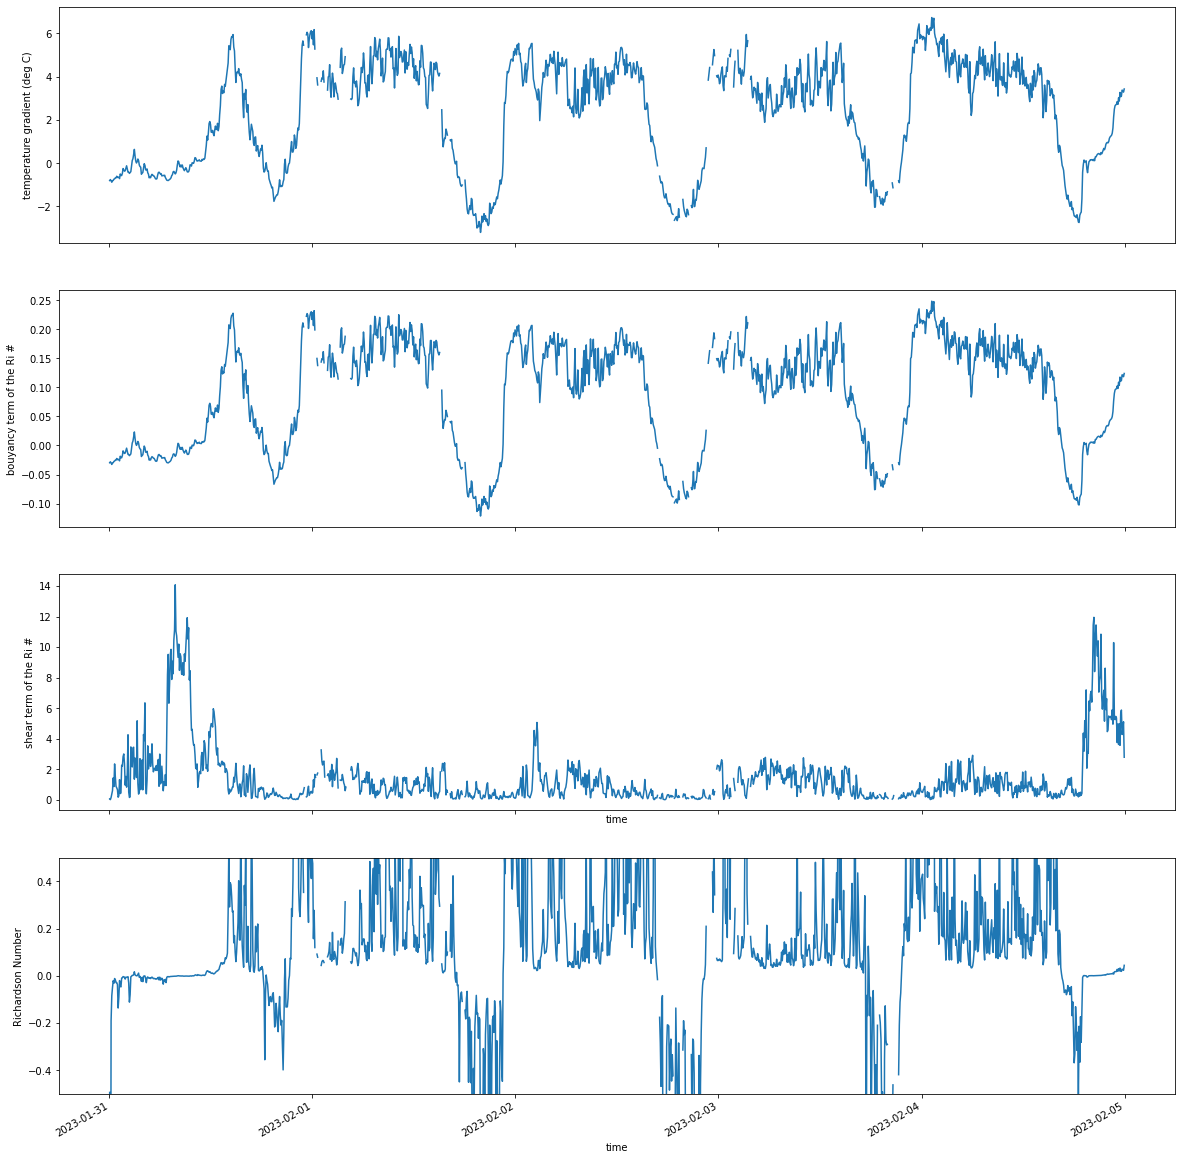

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,1, figsize=(20,20), sharex=True)

temp_gradient.sel().plot(ax=axes[0])
bouyancy_term.sel().plot(ax=axes[1])
flow_shear_term.sel().plot(ax=axes[2])
Ri.sel().plot(ax=axes[3])

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("temperature gradient (deg C)")
axes[1].set_ylabel("bouyancy term of the Ri #")
axes[2].set_ylabel("shear term of the Ri #")
axes[3].set_ylabel("Richardson Number")
axes[3].set_ylim(-0.5, 0.5)

plt.show()

These plots can be hard to interpret.  We can see that the buoyancy term is directly related to the temperature gradient and is positive when it is stable and negative when it is unstable.  First, it's important to consider whether we have continuous snow cover during the period we chose.  You can see pictures [here](https://archive.eol.ucar.edu/docs/isf/projects/SOS/isfs/qcdata/images/20221208/index.html) -- for early December, the plot is mostly snow covered, but some bushes are still apparent above the snow.  

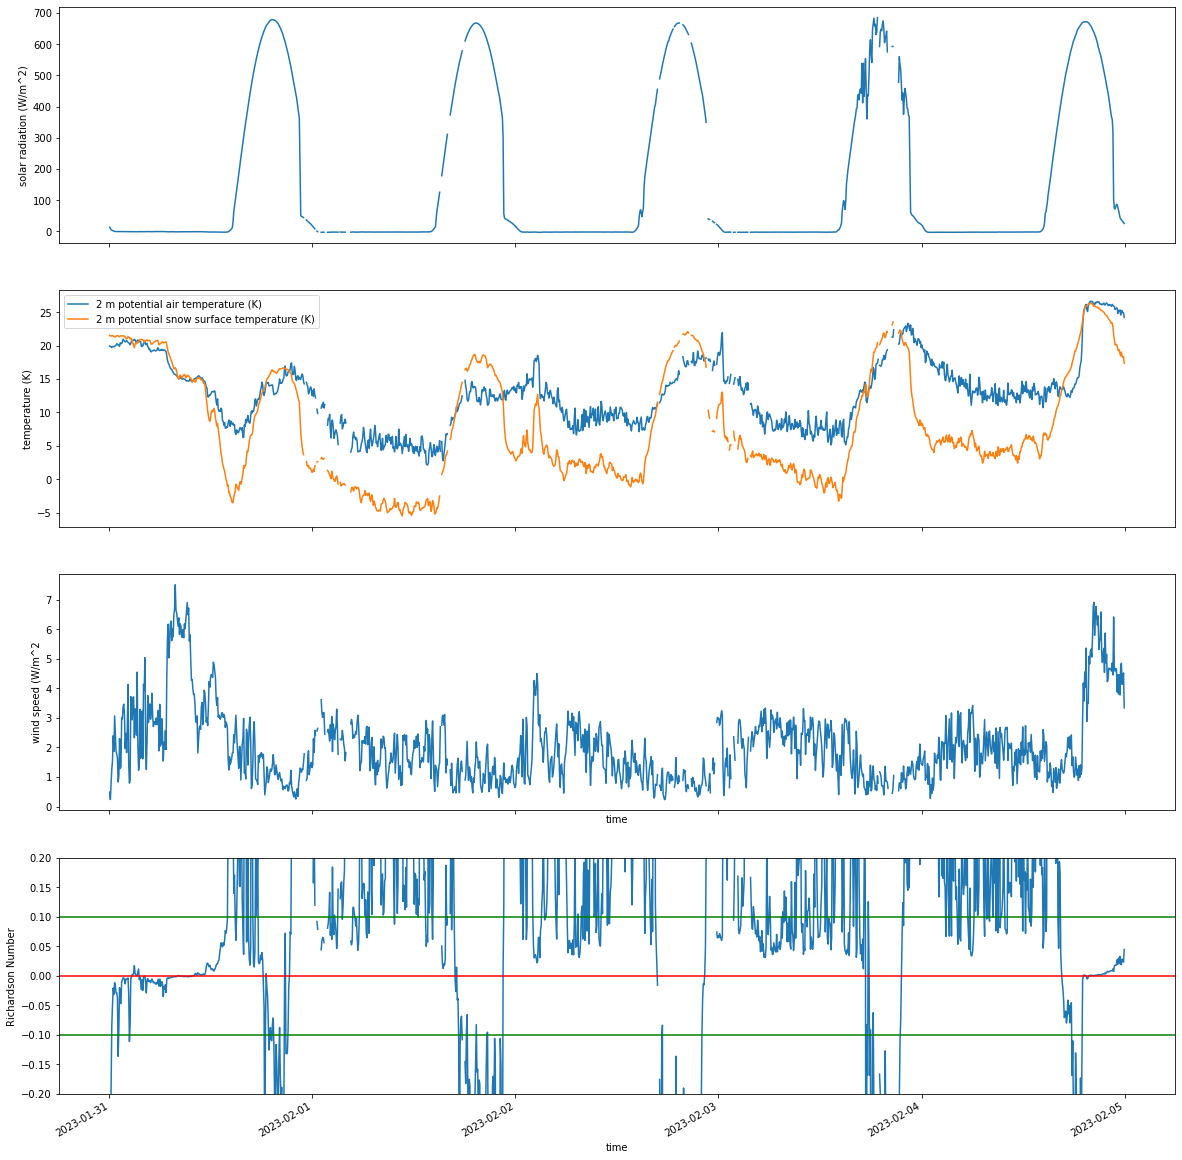

In [15]:
# Let's make some simpler plots for the same time period to help us with interpretation.
fig, axes = plt.subplots(4,1, figsize=(20,20), sharex=True)

# I like to plot shortwave radiation to understand the timing of sunrise and relative cloudiness
sos_ds['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')

# then, I like to see the actual temperatures, before the gradient is calculated
sos_ds['Tpotvirtual_2m_c'].plot(ax=axes[1], label='2 m potential air temperature (K)')
sos_ds['Tsurfpotvirtual_rad_c'].plot(ax=axes[1], label='2 m potential snow surface temperature (K)')

# and the actual wind speed, in units I understand
sos_ds['spd_2m_c'].plot(ax=axes[2], label='2 m wind speed (m/s)')

Ri.sel().plot(ax=axes[3])
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.axhline(y = 0.1, color = 'g', linestyle = '-')
plt.axhline(y = -0.1, color = 'g', linestyle = '-')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].legend()
axes[0].set_ylabel("solar radiation (W/m^2)")
axes[1].set_ylabel("temperature (K)")
axes[2].set_ylabel("wind speed (W/m^2")
axes[3].set_ylabel("Richardson Number")
axes[3].set_ylim(-0.2, 0.2)

plt.show()

You can see the assymmetry in surface temperature vs air temperature.  The surface temperature responds more quickly to solar radiation changes, and rises faster in the morning and drops faster after the sun disappears.  Conditions are close to neutral during the day, or even unstable in the morning, and stable on clear nights through the winter.

### So now, let's see whether our measured fluxes correlate with any of the values we've presented above.

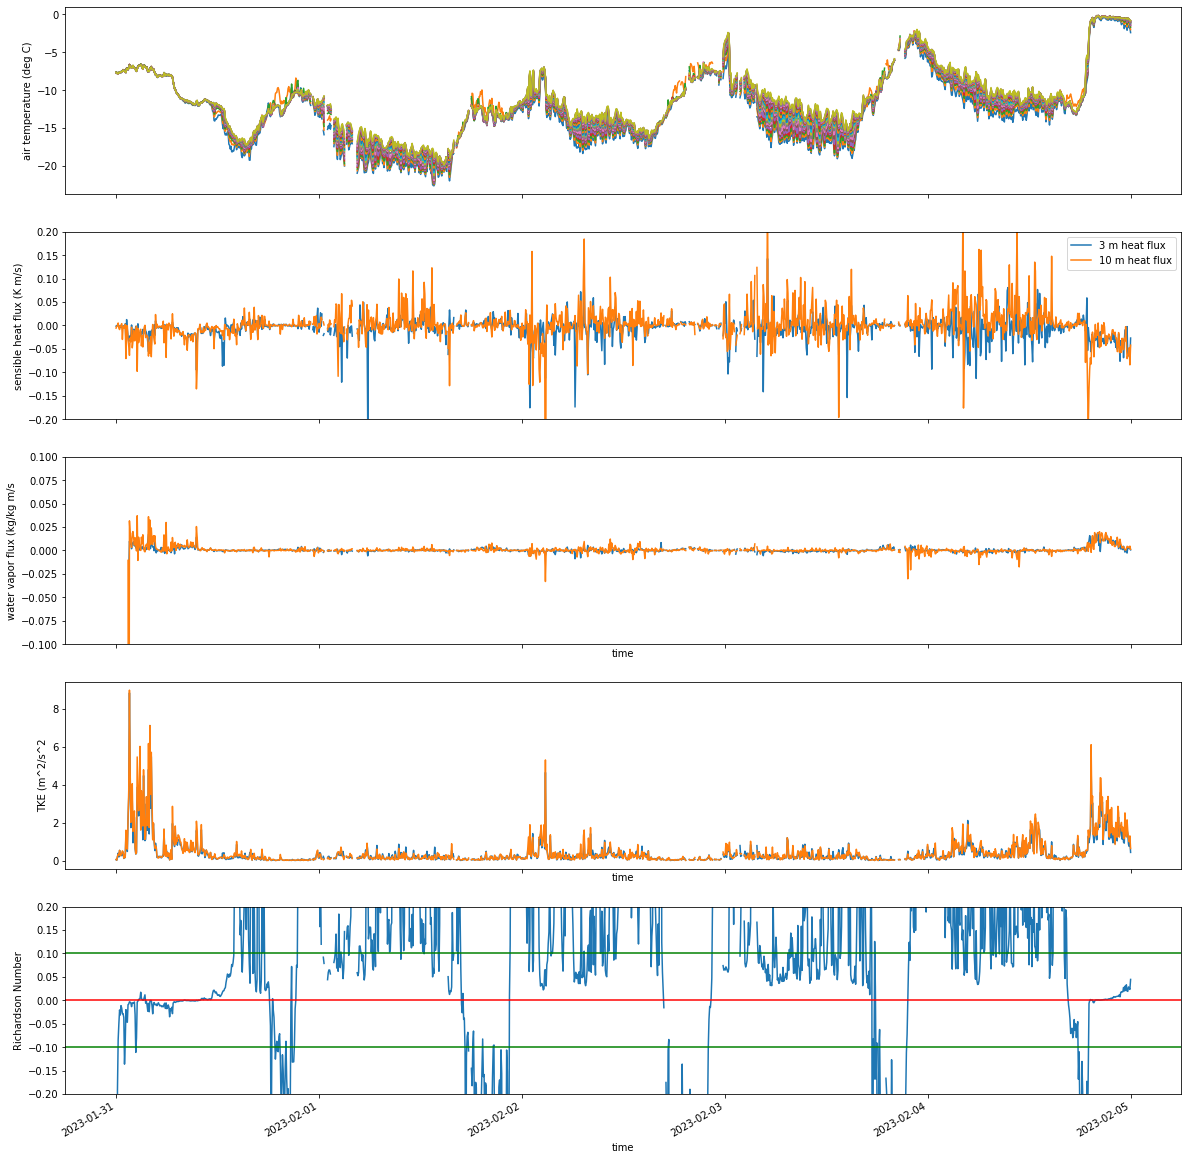

In [16]:
# Let's make some simpler plots for the same time period to help us with interpretation.
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)

# I'm going to keep shortwave radiation to understand the timing of sunrise and relative cloudiness
#sos_ds['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')
# I'm curious about our winds from Lab 6
sos_ds['T_2m_c'].plot(ax=axes[0], label='T at 2 m')
sos_ds['T_3m_c'].plot(ax=axes[0], label='T at 3 m')
sos_ds['T_4m_c'].plot(ax=axes[0], label='T at 4 m')
sos_ds['T_5m_c'].plot(ax=axes[0], label='T at 5 m')
sos_ds['T_6m_c'].plot(ax=axes[0], label='T at 6 m')
sos_ds['T_7m_c'].plot(ax=axes[0], label='T at 7 m')
sos_ds['T_8m_c'].plot(ax=axes[0], label='T at 8 m')
sos_ds['T_9m_c'].plot(ax=axes[0], label='T at 9 m')
sos_ds['T_10m_c'].plot(ax=axes[0], label='T at 10 m')
sos_ds['T_11m_c'].plot(ax=axes[0], label='T at 11 m')
sos_ds['T_12m_c'].plot(ax=axes[0], label='T at 12 m')
sos_ds['T_13m_c'].plot(ax=axes[0], label='T at 13 m')
sos_ds['T_14m_c'].plot(ax=axes[0], label='T at 14 m')
sos_ds['T_15m_c'].plot(ax=axes[0], label='T at 15 m')
sos_ds['T_16m_c'].plot(ax=axes[0], label='T at 16 m')
sos_ds['T_17m_c'].plot(ax=axes[0], label='T at 17 m')
sos_ds['T_18m_c'].plot(ax=axes[0], label='T at 18 m')
sos_ds['T_19m_c'].plot(ax=axes[0], label='T at 19 m')
sos_ds['T_20m_c'].plot(ax=axes[0], label='T at 20 m')

# then, let's look at the sensible heat flux at two heights
sos_ds['w_tc__3m_c'].plot(ax=axes[1], label='3 m heat flux')
sos_ds['w_tc__10m_c'].plot(ax=axes[1], label='10 m heat flux')

# and let's look at the latent heat flux at two heights
sos_ds['w_h2o__3m_c'].plot(ax=axes[2], label='3 m moisture flux')
sos_ds['w_h2o__10m_c'].plot(ax=axes[2], label='10 m moisture flux')

# and let's look at the TKE at two heights
sos_ds['tke_3m_c'].plot(ax=axes[3], label='3 m TKE')
sos_ds['tke_10m_c'].plot(ax=axes[3], label='10 m TKE')

Ri.sel().plot(ax=axes[4])
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.axhline(y = 0.1, color = 'g', linestyle = '-')
plt.axhline(y = -0.1, color = 'g', linestyle = '-')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].legend()
#axes[0].set_ylabel("solar radiation (W/m^2)")
axes[0].set_ylabel("air temperature (deg C)")
axes[1].set_ylabel("sensible heat flux (K m/s)")
axes[1].set_ylim(-0.2, 0.2)
axes[2].set_ylabel("water vapor flux (kg/kg m/s")
axes[2].set_ylim(-0.1, 0.1)
axes[3].set_ylabel("TKE (m^2/s^2")
axes[4].set_ylabel("Richardson Number")
axes[4].set_ylim(-0.2, 0.2)
# Comment out the portion below to see the entire time series you grabbed.
#axes[0].set_xlim(dt.datetime(2023,2,2,0,0,0), dt.datetime(2023,2,2,12,0,0))
#axes[1].set_xlim(dt.datetime(2023,2,2,0,0,0), dt.datetime(2023,2,2,12,0,0))
#axes[2].set_xlim(dt.datetime(2023,2,2,0,0,0), dt.datetime(2023,2,2,12,0,0))
#axes[3].set_xlim(dt.datetime(2023,2,2,0,0,0), dt.datetime(2023,2,2,12,0,0))
#axes[4].set_xlim(dt.datetime(2023,2,2,0,0,0), dt.datetime(2023,2,2,12,0,0))

plt.show()

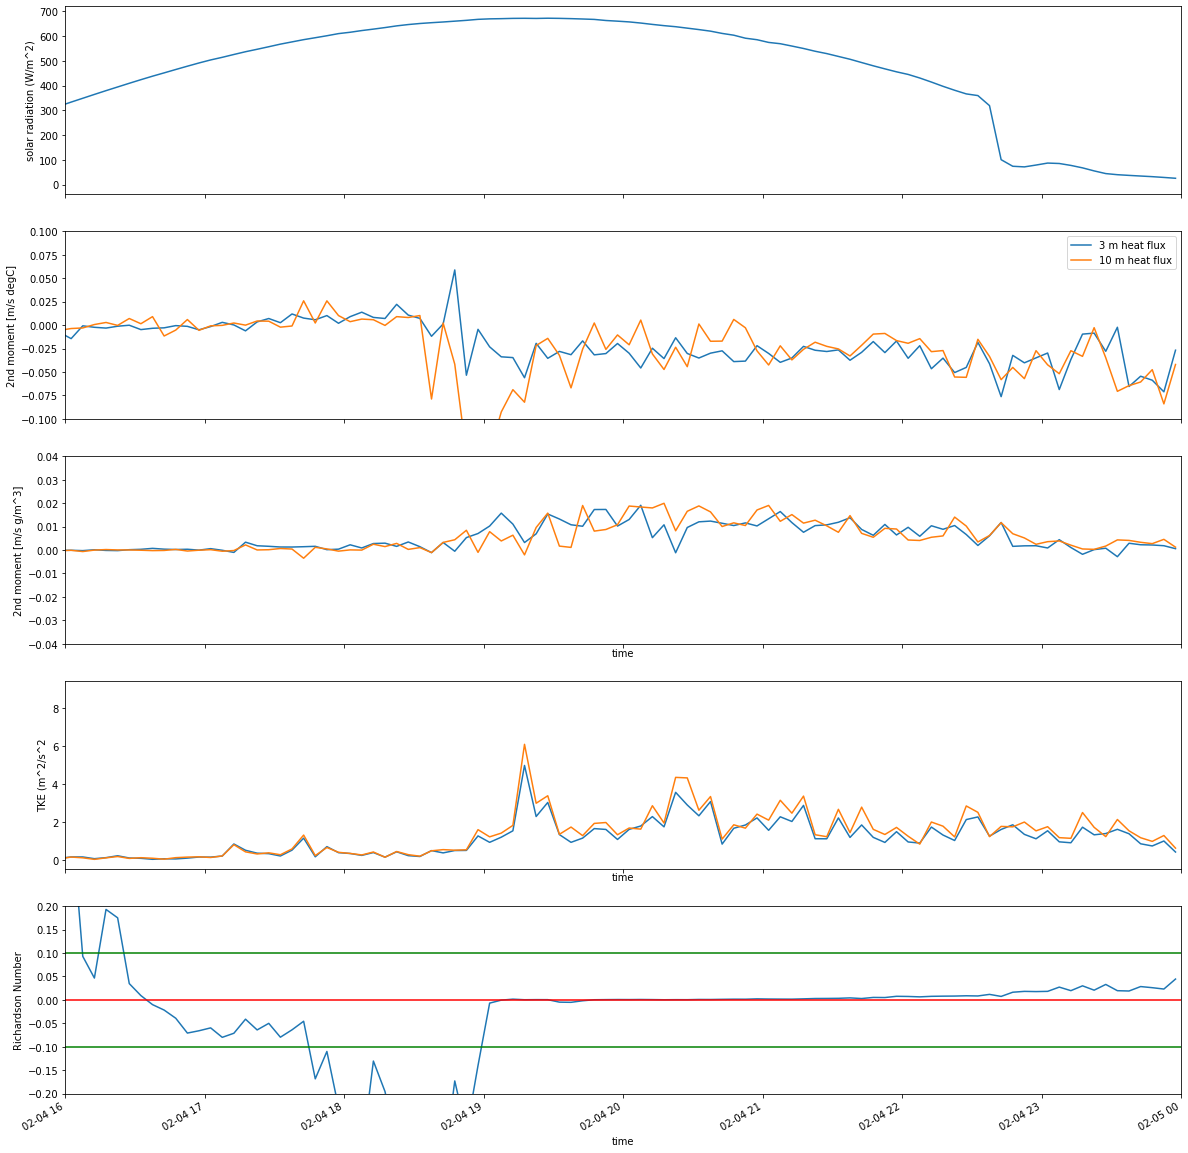

In [17]:
# Let's try zooming in to just one period
# Let's make some simpler plots for the same time period to help us with interpretation.
# We have a warm day of 4 Feb after sunrise, so I'll zoom there
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)

# I'm going to keep shortwave radiation to understand the timing of sunrise and relative cloudiness
sos_ds['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')

# then, let's look at the sensible heat flux at two heights
sos_ds['w_tc__3m_c'].plot(ax=axes[1], label='3 m heat flux')
sos_ds['w_tc__10m_c'].plot(ax=axes[1], label='10 m heat flux')

# and let's look at the latent heat flux at two heights
sos_ds['w_h2o__3m_c'].plot(ax=axes[2], label='3 m moisture flux')
sos_ds['w_h2o__10m_c'].plot(ax=axes[2], label='10 m moisture flux')

# and let's look at the TKE at two heights
sos_ds['tke_3m_c'].plot(ax=axes[3], label='3 m TKE')
sos_ds['tke_10m_c'].plot(ax=axes[3], label='10 m TKE')

Ri.sel().plot(ax=axes[4])
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.axhline(y = 0.1, color = 'g', linestyle = '-')
plt.axhline(y = -0.1, color = 'g', linestyle = '-')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_xlim(dt.datetime(2023,2,4,16,0,0), dt.datetime(2023,2,5))
axes[1].set_xlim(dt.datetime(2023,2,4,16,0,0), dt.datetime(2023,2,5))
axes[1].legend()
axes[0].set_ylabel("solar radiation (W/m^2)")
#axes[1].set_ylabel("sensible heat flux (K m/s)")
axes[1].set_ylim(-0.1, 0.1)
#axes[2].set_ylabel("latent heat flux (kg/kg m/s")
axes[2].set_ylim(-0.04, 0.04)
axes[3].set_ylabel("TKE (m^2/s^2")
axes[4].set_ylabel("Richardson Number")
axes[4].set_ylim(-0.2, 0.2)
axes[2].set_xlim(dt.datetime(2023,2,4,16,0,0), dt.datetime(2023,2,5))
axes[3].set_xlim(dt.datetime(2023,2,4,16,0,0), dt.datetime(2023,2,5))
axes[4].set_xlim(dt.datetime(2023,2,4,16,0,0), dt.datetime(2023,2,5))
plt.show()

### Discussion
For this example, it looks like sensible and latent heat fluxes tend to be of similar magnitude and in opposite directions and that TKE is largest during periods of neutral stability.  These are periods when the surface temperature closely matches the air temperature, which makes sense, as everything is well mixed.  We can try some simple scatter plots to see if our impression of correlations across the timeseries holds in a scatter of the data.  It's also likely that on different days, with different conditions, we could get different relationships.  What do these plots look like if you pick the big blowing snow day on 22 December?  What do they look like after the dust event?  Or when we have more patchy snow?  Are there big differences between cloudy and sunny days?

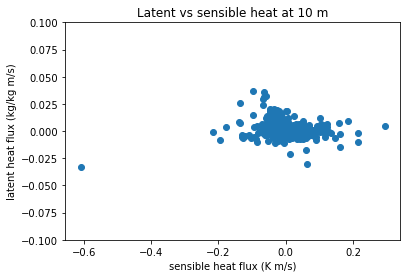

In [18]:
# create a scatter plot of 10 m fluxes
plt.scatter(sos_ds['w_tc__10m_c'], sos_ds['w_h2o__10m_c'])

# set axis labels and title
plt.xlabel('sensible heat flux (K m/s)')
plt.ylabel('latent heat flux (kg/kg m/s)')
plt.title('Latent vs sensible heat at 10 m')

plt.ylim(-0.1, 0.1)

# show the plot
plt.show()

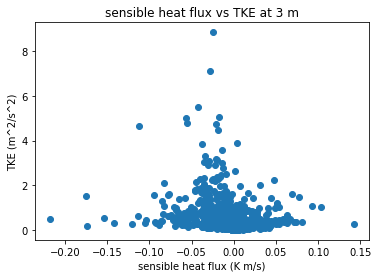

In [19]:
# create a scatter plot of 3 m fluxes
plt.scatter(sos_ds['w_tc__3m_c'], sos_ds['tke_3m_c'])

# set axis labels and title
plt.xlabel('sensible heat flux (K m/s)')
plt.ylabel('TKE (m^2/s^2)')
plt.title('sensible heat flux vs TKE at 3 m')

# show the plot
plt.show()

In general, the snow cools and moistens the air (or rather, the air heats the snow) -- what other relationships can you find?  What do you think controls the slope of the best fit line to sensible vs latent heat flux?  Are there physics that should relate the two?

What if we sort our data by a certain type of conditions and make a histogram?  I'm hypothesizing that sensible and latent heat flux only matter when TKE is greater than 2.   You can try other combinations.

In [20]:
# Select the variable you want to use for splitting
split_var = sos_ds['tke_3m_c']
split_value = 2

# Split the dataset into two groups based on the variable values
group_greater = sos_ds.where(split_var > split_value, drop=True)
group_less = sos_ds.where(split_var <= split_value, drop=True)

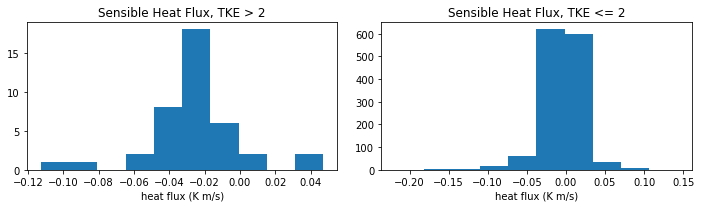

In [21]:
# Now, make histograms for each
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax1.hist(group_greater['w_tc__3m_c'], bins=10)
#ax1.set_xlim((1e4,1.4e5))
ax1.set_xlabel('heat flux (K m/s)')
ax1.set_title('Sensible Heat Flux, TKE > 2')

ax2.hist(group_less['w_tc__3m_c'], bins=10)
#ax2.set_xlim((1e4,1.4e5))
ax2.set_xlabel('heat flux (K m/s)')
ax2.set_title('Sensible Heat Flux, TKE <= 2');

plt.tight_layout()

### Converting Kinematic Fluxes into Total Amounts: Mass and Energy Transfer

As many of our questions focus on how much snow water equivalent is lost to the atmosphere from the process of sublimation, we want to convert our water vapor flux to a total mass lost over time.  For this, it's important to check the units of our data.  Here, we have perturbations in water vapor density (in $g m^{-3}$) times perturbations in vertical velocity (in $m s^{-1}$), for a vertical flux in water vapor mass (in $g m^{-2} s^{-1}$).


(-0.01, 0.02)

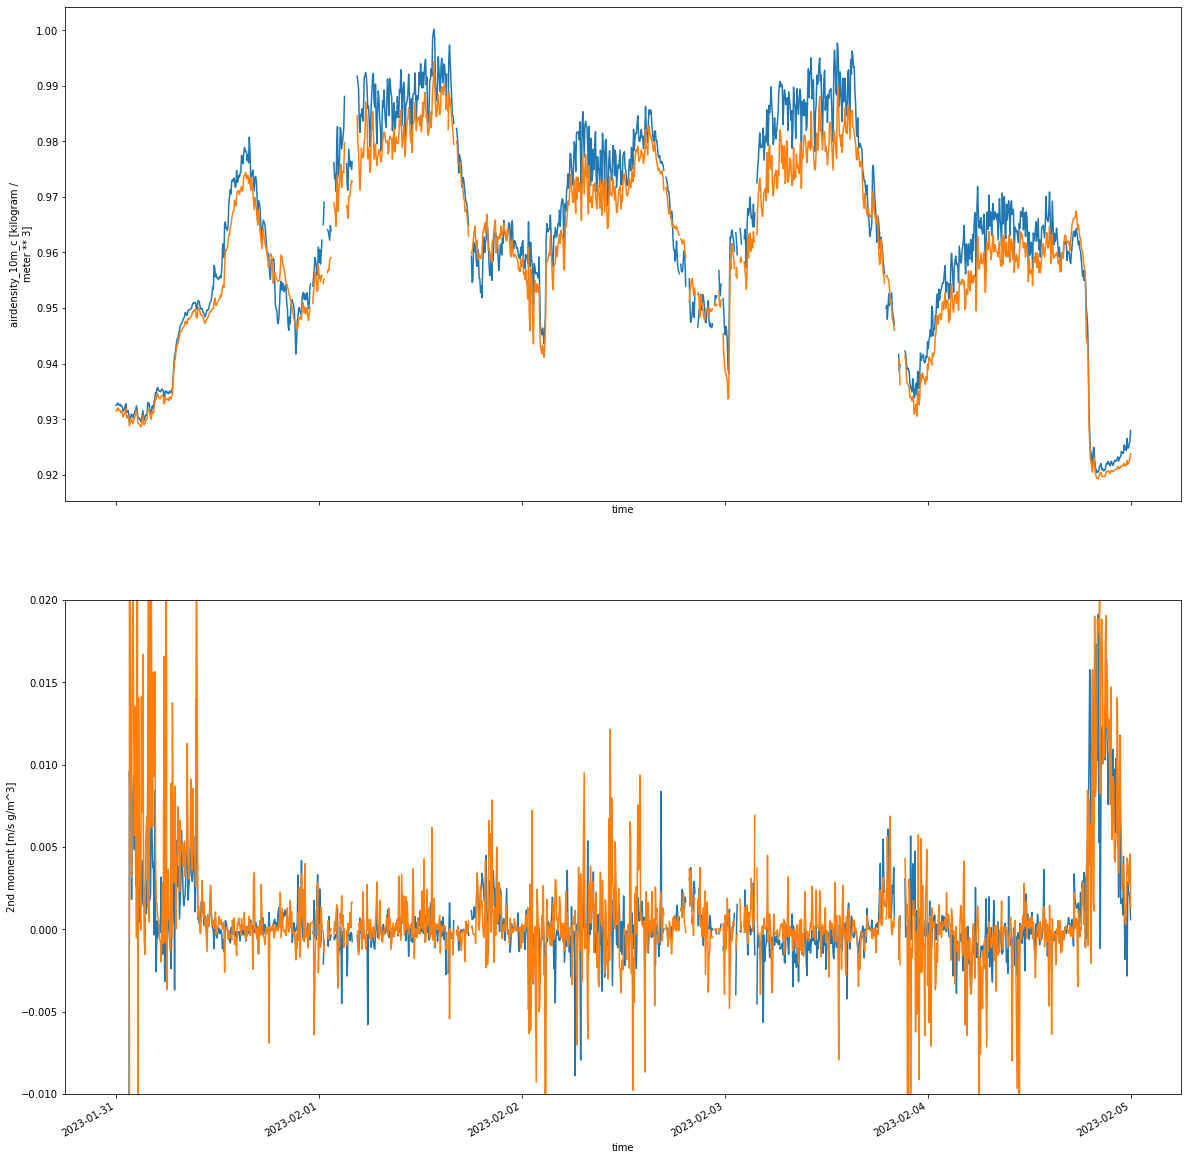

In [22]:
#We look at our water vapor flux again and air density too
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True)


#  let's look at the density at two heights
sos_ds['airdensity_3m_c'].plot(ax=axes[0], label='3 m air density')
sos_ds['airdensity_10m_c'].plot(ax=axes[0], label='10 m air density')

# and let's look at the latent heat flux at two heights
sos_ds['w_h2o__3m_c'].plot(ax=axes[1], label='3 m specific humidity flux')
sos_ds['w_h2o__10m_c'].plot(ax=axes[1], label='10 m specific humidity flux')
axes[1].set_ylim(-0.01, 0.02)




In [23]:
# Over the entire period we downloaded here, we can sum the flux times the time interval in seconds
totalwater_3m_h2o = 5*60*np.sum(sos_ds['w_h2o__3m_c'])
print(totalwater_3m_h2o)

<xarray.DataArray 'w_h2o__3m_c' ()>
array(207.78627992)


So over these five days, about 208 grams of water were lost from a $m^2$ patch of the snowpack.  Does that make sense to you?  

Again, it's important for us to always check units and to convert to values that make sense to us.  We know that the density of water is about $ 1000 kg m^{-3}$, or $ 1 g cm^{-3} $.     We know that our snowpack at this time was about 1 m deep and about 30% density.  So, the total snowpack had 300 kg, or 300,000 g of water in it.  So, this would suggest that we have removed less than 0.1% of the snowpack by sublimation during this timeperiod.  

#### Hypothesis 1: I have bad outliers in this dataset that should not be summed.

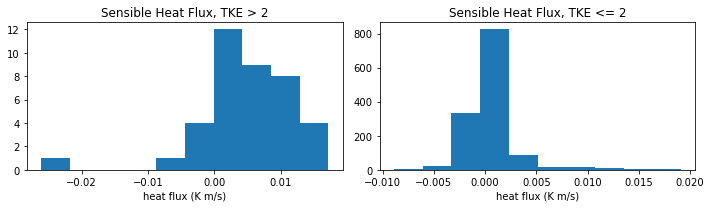

In [25]:
# Now, make histograms for each
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax1.hist(group_greater['w_h2o__3m_c'], bins=10)
#ax1.set_xlim((1e4,1.4e5))
ax1.set_xlabel('heat flux (K m/s)')
ax1.set_title('Sensible Heat Flux, TKE > 2')

ax2.hist(group_less['w_h2o__3m_c'], bins=10)
#ax2.set_xlim((1e4,1.4e5))
ax2.set_xlabel('heat flux (K m/s)')
ax2.set_title('Sensible Heat Flux, TKE <= 2');

plt.tight_layout()

In [38]:
# I'm going to try exluding anything greater than 0.02 or less than -0.02 and resum, just in case
# most data fit in this range.
testflux = sos_ds['w_h2o__3m_c'].where((sos_ds['w_h2o__3m_c'] < 0.02) & (sos_ds['w_h2o__3m_c'] > -0.02), drop=True)
totalwater_3m_h2o_v2 = 5*60*np.sum(testflux)
print(totalwater_3m_h2o_v2)

<xarray.DataArray 'w_h2o__3m_c' ()>
array(215.60726166)


For this timeperiod, this doesn't change the value much.
#### Hypothesis 2: Maybe sublimation really didn't remove much water this week!
But maybe it removed some energy?

In [39]:
# latent heat of fusion for the ice-water transition
L_f = 334 #kJ/kg
# latent heat of vaporization for the water-vapor transition (evaporation)
L_v = 2256 #kJ/kg
# latent heat of vaporization for the ice-vapor transition (sublimation)
L_s = L_f + L_v #kJ/kg or J/g

print(totalwater_3m_h2o_v2*L_s)

<xarray.DataArray 'w_h2o__3m_c' ()>
array(558422.80769348)


But does that number make sense?  It's in joules  How much solar radiation came in over the same time (presuming that 85% was reflected)?  We measure solar radiation in W/m^s = 1 J/(s m^2)

In [41]:
totalsolar_tosnow = 0.15*5*60*np.sum(sos_ds['Rsw_in_9m_d'])
print(totalsolar_tosnow)

<xarray.DataArray 'Rsw_in_9m_d' ()>
array(9753536.953125)


In [42]:
print(totalwater_3m_h2o_v2*L_s/totalsolar_tosnow)

<xarray.DataArray ()>
array(0.05725336)


Looks like only 6% of net solar radiation goes into the energy required for sublimation.  Wait for exciting lab 8 to figure out how we put all the mass and energy balance together to figure out when snow is ready to melt and how fast it will melt.